# Train Detectron2 with Custom COCO Datasets

# Clone Mask-RCNN Function

In [1]:
import sys
!git clone https://github.com/ARG-NCTU/Mask-RCNN-Detectron2.git
sys.path.append('/content/Mask-RCNN-Detectron2')

Cloning into 'Mask-RCNN-Detectron2'...
remote: Enumerating objects: 852, done.
remote: Counting objects: 100% (852/852), done.
remote: Compressing objects: 100% (663/663), done.
remote: Total 852 (delta 163), reused 849 (delta 160), pack-reused 0
Receiving objects: 100% (852/852), 35.18 MiB | 36.87 MiB/s, done.
Resolving deltas: 100% (163/163), done.


# Install related module

Note : After running the command below , you need to restart the notebook ! and can skip the command below

In [2]:
!pip install -U git+https://github.com/facebookresearch/fvcore.git
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-3ba75o1v
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-3ba75o1v
     |████████████████████████████████| 276kB 14.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=44576 sha256=304ff9dd6a33064819687eebaf6f2aaad7458696f67504ad59f37cb7712c22ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fhl7z2r/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=c125b102a94c770f9367bfa3945bb9a08ea0839705e554785951baec8378b6e2
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10508 sha256=7680fcad556ec0875de6d13bf0c72052f25045a544a3f2176a27e516e6126dcd
  Stored in directory: /root/.cache/pip/wheels/9e/01/e

# Import Libraries

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import logging
import gdown
import torch
from zipfile import ZipFile

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Download Datasets

In [3]:
dataset_url = 'https://drive.google.com/u/1/uc?id=1gyom0ysZ3GauPWd26f3_Przw2VK3tXuD&export=download'
dataset_name = 'subt-urban-coco-dataset'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
    zip1 = ZipFile(dataset_name + '.zip')
    zip1.extractall(dataset_name)
    zip1.close()

print("Finished downloading dataset.")

Downloading...
From: https://drive.google.com/u/1/uc?id=1gyom0ysZ3GauPWd26f3_Przw2VK3tXuD&export=download
To: /content/subt-urban-coco-dataset.zip
132MB [00:01, 67.3MB/s]


Finished downloading dataset.


# Register your own data set in coco format

In [4]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances('subt_train', {}, 
                        '/content/subt-urban-coco-dataset/SubT_urban_train.json', 
                       '/content/subt-urban-coco-dataset/SubT_urban_train')
register_coco_instances('subt_val', {}, 
                        '/content/subt-urban-coco-dataset/SubT_urban_val.json', 
                       '/content/subt-urban-coco-dataset/SubT_urban_val')

In [5]:
subt_metadata = MetadataCatalog.get("subt_val")
dataset_dicts = DatasetCatalog.get("subt_val")
subt_metadata


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Metadata(evaluator_type='coco', image_root='/content/subt-urban-coco-dataset/SubT_urban_val', json_file='/content/subt-urban-coco-dataset/SubT_urban_val.json', name='subt_val', thing_classes=['_background_', 'backpack', 'vent', 'phone', 'suvivor'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4})

# Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the datase

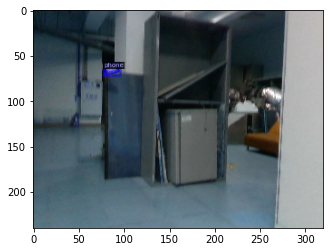

In [6]:
import random

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=subt_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1], cmap='nipy_spectral')
    cv2.waitKey(0)

# Change configuration parameters

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the dataset.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("subt_train",)
cfg.DATASETS.TEST = ("subt_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 6 #Batch size
ITERS_IN_ONE_EPOCH = 610 #dataset_imgs/batch_size  
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS

cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval

# Training

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)
trainer.train()

[01/01 11:03:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 88.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[01/01 11:03:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()


[01/01 11:03:48 d2.utils.events]:  eta: 10:48:30  iter: 19  total_loss: 2.998  loss_cls: 1.799  loss_box_reg: 0.4846  loss_mask: 0.6947  loss_rpn_cls: 0.01079  loss_rpn_loc: 0.003485  time: 1.2727  data_time: 0.1325  lr: 4.9953e-06  max_mem: 5945M
[01/01 11:04:15 d2.utils.events]:  eta: 11:02:02  iter: 39  total_loss: 2.879  loss_cls: 1.67  loss_box_reg: 0.4629  loss_mask: 0.6913  loss_rpn_cls: 0.01163  loss_rpn_loc: 0.003423  time: 1.3136  data_time: 0.1333  lr: 9.9902e-06  max_mem: 5945M
[01/01 11:04:43 d2.utils.events]:  eta: 11:27:28  iter: 59  total_loss: 2.579  loss_cls: 1.438  loss_box_reg: 0.4552  loss_mask: 0.6852  loss_rpn_cls: 0.0105  loss_rpn_loc: 0.003998  time: 1.3448  data_time: 0.1341  lr: 1.4985e-05  max_mem: 5945M
[01/01 11:05:11 d2.utils.events]:  eta: 11:38:17  iter: 79  total_loss: 2.282  loss_cls: 1.128  loss_box_reg: 0.4703  loss_mask: 0.6745  loss_rpn_cls: 0.008376  loss_rpn_loc: 0.004194  time: 1.3612  data_time: 0.1317  lr: 1.998e-05  max_mem: 5945M
[01/01 11:

# Make a prediction

Download a pre-trained SubT model

In [ ]:
models_url = "https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1LjW4-4YAL81TXkxL9tzm0NaiOhuJVpNg&export=download"
models_name = "model_0096989.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.")

NameError: ignored

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0096989.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("subt_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')